# Proyecto Final "Telecomunicaciones: identificación de operadores ineficaces"

# Telefonía virtual "CallMeMaybe"

1. INTRODUCCIÓN 


El presente análisis tiene como objetivo evaluar la eficiencia operativa de los operadores de telecomunicaciones de la empresa "CallMeMaybe", a partir de registros de llamadas y datos de clientes.
Se buscó identificar patrones de desempeño y detectar operadores ineficaces, considerando indicadores de tiempo de espera, tasa de llamadas perdidas y volumen de llamadas salientes.

2. DESCRIPCIÓN DE LOS DATOS 

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido *telecom_dataset_us.csv* contiene las siguientes columnas:

- 'user_id': ID de la cuenta de cliente
- 'date': fecha en la que se recuperaron las estadísticas
- 'direction': dirección" de llamada ('out' para saliente, 'in' para entrante)
- 'internal': si la llamada fue interna (entre los operadores de un cliente o clienta)
- 'operator_id': identificador del operador
- 'is_missed_call': si fue una llamada perdida
- 'calls_count': número de llamadas
- 'call_duration': duración de la llamada (sin incluir el tiempo de espera)
- 'total_call_duration': duración de la llamada (incluido el tiempo de espera)

El conjunto de datos *telecom_clients_us.csv* tiene las siguientes columnas:

- 'user_id': ID de usuario/a
- 'tariff_plan': tarifa actual de la clientela
- 'date_start': fecha de registro de la clientela


3. INICIALIZACIÓN 

In [32]:
# Se cargan todas las librerias necesarias 

# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import math as mth

# Pruebas estadísticas
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

In [33]:
# Se cargan los archivos de datos en DataFrame
calls_df = pd.read_csv('telecom_dataset_new.csv', sep=',')
clients_df = pd.read_csv('telecom_clients.csv', sep=',')

In [34]:
# Se imprime la información general y resumida de sobre los datos de las llamadas 
print("* calls_df *")
print(calls_df.info())
print(calls_df.describe(include='all'))

* calls_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None
              user_id                       date direction internal  \
count    53902.000000                      53902     53902    53785   
unique            NaN                        119         2        2   
top               NaN  2019-11-25 00:00:

In [35]:
# Se imprime una mnuestra de los datos de las llamadas 
calls_df.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


In [36]:
# Se imprime la información general y resumida de los datos de los clientes 
print("* clients_df *")
print(clients_df.info())
print(clients_df.describe(include='all'))

* clients_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
              user_id tariff_plan  date_start
count      732.000000         732         732
unique            NaN           3          73
top               NaN           C  2019-09-24
freq              NaN         395          24
mean    167431.927596         NaN         NaN
std        633.810383         NaN         NaN
min     166373.000000         NaN         NaN
25%     166900.750000         NaN         NaN
50%     167432.000000         NaN         NaN
75%     167973.000000         NaN         NaN
max     168606.000000         NaN         NaN


In [37]:
# Se imprime una muestra de los datos de los clientes 
clients_df.head(10)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


3.1 PREPARACIÓN DE LOS DATOS

In [38]:
# Tranformamos columnas de fecha 
calls_df['date'] = pd.to_datetime(calls_df['date'])
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'])

In [39]:
# Calculamos tiempo de espera con 'waiting_time'
calls_df['waiting_time'] = calls_df['total_call_duration'] - calls_df['call_duration']

In [40]:
# Revisamos llamdas internas 
calls_df['internal'] = calls_df['internal'].astype(bool)

In [41]:
# Preparamos agregados por operador 
operator_stats = calls_df.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    total_missed_calls=('is_missed_call', 'sum'),
    avg_waiting_time=('waiting_time', 'mean'),
    total_out_calls=('calls_count', lambda x: x[calls_df.loc[x.index, 'direction']=='out'].sum()),
    total_in_calls=('calls_count', lambda x: x[calls_df.loc[x.index, 'direction']=='in'].sum())
).reset_index()

# Tasa de llamadas perdidas por operador
operator_stats['missed_call_rate'] = operator_stats['total_missed_calls'] / operator_stats['total_calls']

operator_stats.head()

,operator_id,total_calls,total_missed_calls,avg_waiting_time,total_out_calls,total_in_calls,missed_call_rate
0,879896.0,1131,50,110.671875,1071,60,0.044209
1,879898.0,7974,100,450.087649,7856,118,0.012541
2,880020.0,54,7,15.181818,46,8,0.129630
3,880022.0,219,33,57.565789,211,8,0.150685
4,880026.0,2439,94,121.171717,2414,25,0.038540


3.2 ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)

In [42]:
# Estadísticas descriptivas
display(calls_df.describe())

# Comprobamos nuevamente valores nulos
print("\nValores nulos por columna:")
print(calls_df.isna().sum())

,user_id,operator_id,calls_count,call_duration,total_call_duration,waiting_time
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297,290.448870
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763,1127.905654
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000,17.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000,55.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000,201.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,46474.000000



Valores nulos por columna:
user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
waiting_time              0
dtype: int64


In [43]:
# Estadísticas descriptivas
display(clients_df.describe())

# Comprobamos nuevamente valores nulos
print("\nValores nulos por columna:")
print(clients_df.isna().sum())

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000



Valores nulos por columna:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


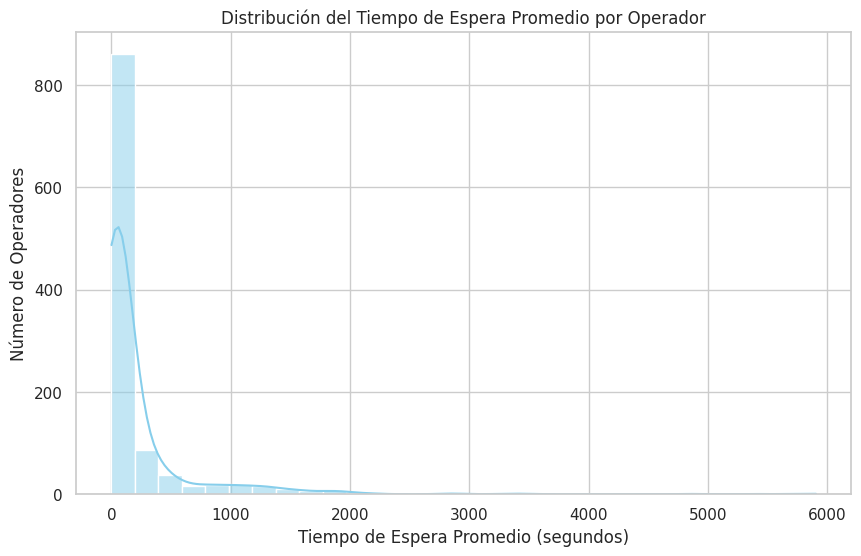

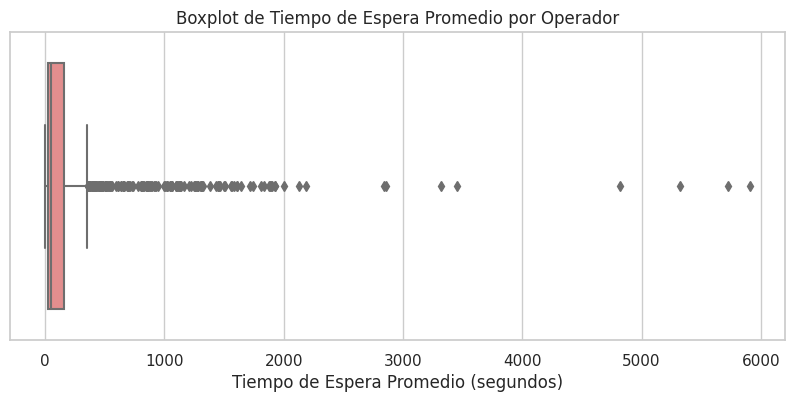

In [44]:
# Distribución del tiempo de espera promedio

# Configuración general de gráficos
sns.set(style="whitegrid")

# Histograma del tiempo de espera promedio
plt.figure(figsize=(10,6))
sns.histplot(operator_stats['avg_waiting_time'], bins=30, kde=True, color='skyblue')
plt.title("Distribución del Tiempo de Espera Promedio por Operador")
plt.xlabel("Tiempo de Espera Promedio (segundos)")
plt.ylabel("Número de Operadores")
plt.show()

# Boxplot para detectar outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=operator_stats['avg_waiting_time'], color='lightcoral')
plt.title("Boxplot de Tiempo de Espera Promedio por Operador")
plt.xlabel("Tiempo de Espera Promedio (segundos)")
plt.show()

In [45]:
# Tabla de percentiles del tiempo de espera promedio
waiting_time_summary = operator_stats['avg_waiting_time'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("Resumen del Tiempo de Espera Promedio por Operador (segundos):")
print(waiting_time_summary)

Resumen del Tiempo de Espera Promedio por Operador (segundos):
count    1092.000000
mean      215.446189
std       504.915578
min         0.000000
25%        23.058824
50%        46.259878
75%       155.541011
90%       546.651471
95%      1127.366054
99%      1935.694780
max      5907.443038
Name: avg_waiting_time, dtype: float64


Interpretación

- 25% de operadores tienen ≤23 seg de espera promedio.
- La mitad de los operadores tienen ≤46 seg de espera promedio.
- 25% de operadores tienen más de 156 seg de espera promedio.
- 10% de operadores tienen tiempos altos, posibles ineficaces.
- Solo el 5% de operadores están extremadamente lentos.
- Top 1% de operadores muy ineficaces en tiempo de espera.
- Casos extremos de espera (≈1.6 horas).

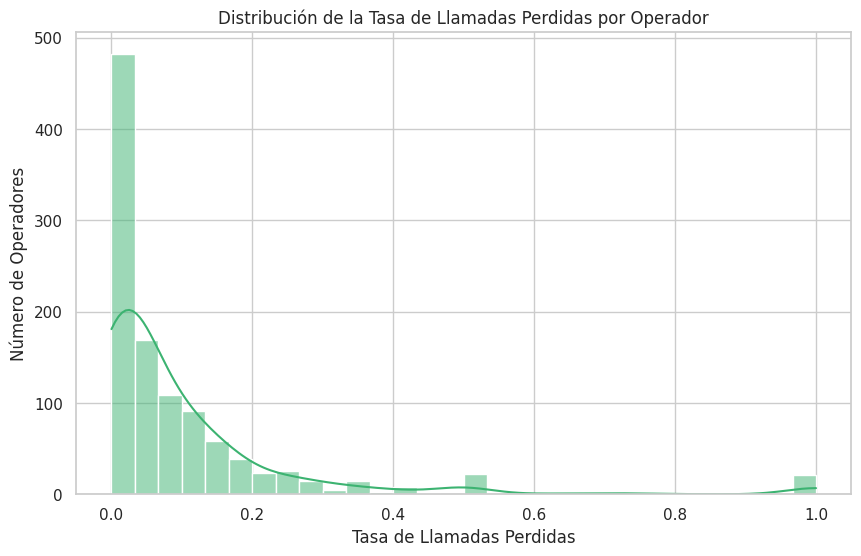

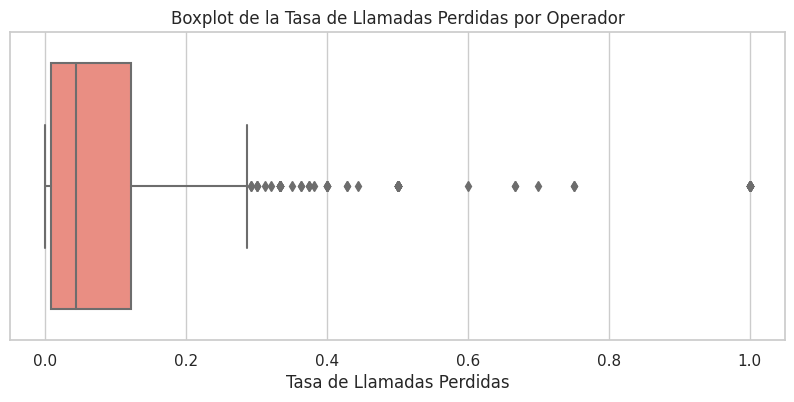

In [46]:
# Distribución de la tasa de llamadas perdidas

# Histograma de la tasa de llamadas perdidas
plt.figure(figsize=(10,6))
sns.histplot(operator_stats['missed_call_rate'], bins=30, kde=True, color='mediumseagreen')
plt.title("Distribución de la Tasa de Llamadas Perdidas por Operador")
plt.xlabel("Tasa de Llamadas Perdidas")
plt.ylabel("Número de Operadores")
plt.show()

# Boxplot para detectar outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=operator_stats['missed_call_rate'], color='salmon')
plt.title("Boxplot de la Tasa de Llamadas Perdidas por Operador")
plt.xlabel("Tasa de Llamadas Perdidas")
plt.show()

In [47]:
# Tabla de percentiles de las llamadas perdidas 
missed_call_summary = operator_stats['missed_call_rate'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])
print("Resumen de la Tasa de Llamadas Perdidas por Operador:")
print(missed_call_summary)

Resumen de la Tasa de Llamadas Perdidas por Operador:
count    1092.000000
mean        0.100619
std         0.168800
min         0.000000
25%         0.008269
50%         0.043151
75%         0.121283
90%         0.250000
95%         0.400000
99%         1.000000
max         1.000000
Name: missed_call_rate, dtype: float64


Interpretación 

- 25% de operadores pierden menos del 1% de llamadas.
- La mitad de operadores pierde menos del 4.3%.
- 25% de operadores pierde más del 12% de llamadas.
- 10% de operadores pierde más del 25% de llamadas. 
- Top 5% de operadores con tasas altas de llamadas perdidas.
- Top 1% de operadores pierden todas las llamadas asignadas.

In [48]:
# Identifiación de operadores ineficaces 

# Definimos umbrales a partir de percentiles
waiting_time_threshold = operator_stats['avg_waiting_time'].quantile(0.75)
missed_call_threshold = operator_stats['missed_call_rate'].quantile(0.75)

# Filtramos operadores ineficaces
inefficient_operators = operator_stats[
    (operator_stats['avg_waiting_time'] > waiting_time_threshold) &
    (operator_stats['missed_call_rate'] > missed_call_threshold)
].copy()

# Ordenar por ineficacia
inefficient_operators.sort_values(by=['avg_waiting_time','missed_call_rate'], ascending=False, inplace=True)

print(f"Total de operadores ineficaces: {inefficient_operators.shape[0]}")
inefficient_operators.head()

Total de operadores ineficaces: 0


,operator_id,total_calls,total_missed_calls,avg_waiting_time,total_out_calls,total_in_calls,missed_call_rate


El resultado de Total de operadores ineficaces: 0 indica que ningún operador supera ambos umbrales del percentil 75, puede ser por avrias razones: puede haber operadores que tienen tiempo de espera alto pero bajo indice de llamadas perdidas u utros operadores tienen alta tasa de llamadas perdidas pero su tiempo de espera es bajo.

In [49]:
# Definimos umbrales a partir de percentiles
waiting_time_threshold = operator_stats['avg_waiting_time'].quantile(0.75)
missed_call_threshold = operator_stats['missed_call_rate'].quantile(0.75)

# Filtramos operadores ineficaces
inefficient_operators = operator_stats[
    (operator_stats['avg_waiting_time'] > waiting_time_threshold) |
    (operator_stats['missed_call_rate'] > missed_call_threshold)
].copy()

# Ordenar por ineficacia
inefficient_operators.sort_values(by=['avg_waiting_time','missed_call_rate'], ascending=False, inplace=True)

print(f"Total de operadores ineficaces: {inefficient_operators.shape[0]}")
inefficient_operators.head(10)

Total de operadores ineficaces: 546


,operator_id,total_calls,total_missed_calls,avg_waiting_time,total_out_calls,total_in_calls,missed_call_rate
551,925922.0,22210,33,5907.443038,21754,456,0.001486
29,885890.0,66016,110,5727.133574,64653,1363,0.001666
583,929428.0,24572,35,5325.342857,24572,0,0.001424
28,885876.0,66049,135,4816.241379,64897,1152,0.002044
317,908640.0,16699,24,3456.461538,16699,0,0.001437
582,929426.0,12041,35,3316.558824,12041,0,0.002907
843,945278.0,4314,25,2858.479167,4314,0,0.005795
448,919364.0,5096,23,2841.465116,5096,0,0.004513
847,945286.0,7919,37,2185.774648,7919,0,0.004672
870,945904.0,4080,19,2128.657895,4080,0,0.004657


Interpretación 

- Hay operadores que tienen tiempos de espera extremadamente bajos incluso si la tasa de llamadas perdidas es baja
- Otros operadores destacan en llamadas perdidas altas, aunque el tiempo se espera promedio es bajo

El siguiente gráfico busca vizualizar los operadores ineficaces en función de la tasa de llamadas perdidas y el tiempo de espera promedio.

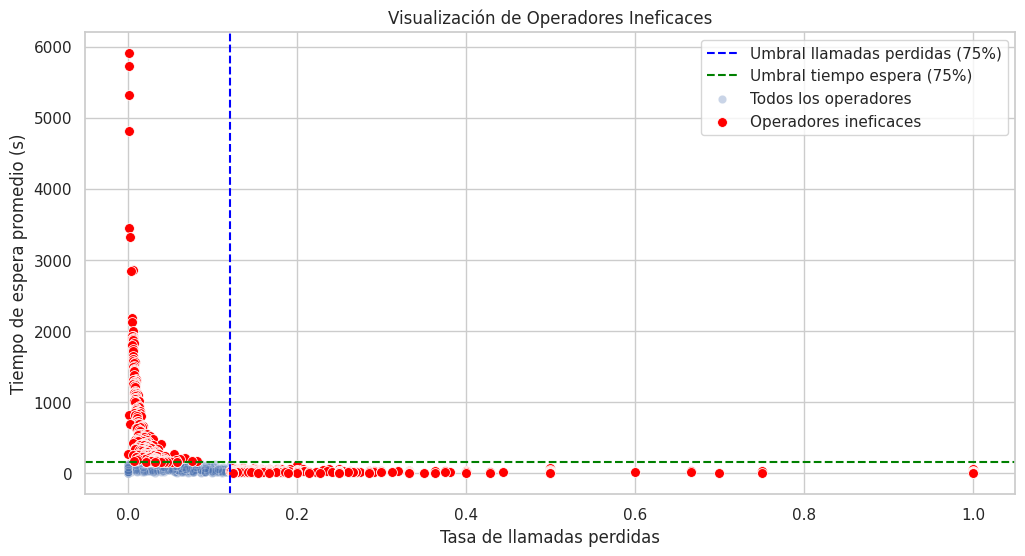

In [50]:
plt.figure(figsize=(12,6))

# Todos los operadores
sns.scatterplot(
    data=operator_stats, 
    x='missed_call_rate', 
    y='avg_waiting_time',
    alpha=0.3, 
    label='Todos los operadores'
)

# Operadores ineficaces
sns.scatterplot(
    data=inefficient_operators, 
    x='missed_call_rate', 
    y='avg_waiting_time',
    color='red', 
    s=50,
    label='Operadores ineficaces'
)

# Líneas de umbral
plt.axvline(x=missed_call_threshold, color='blue', linestyle='--', label='Umbral llamadas perdidas (75%)')
plt.axhline(y=waiting_time_threshold, color='green', linestyle='--', label='Umbral tiempo espera (75%)')

plt.title('Visualización de Operadores Ineficaces')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Tiempo de espera promedio (s)')
plt.legend()
plt.show()

Interpretación:

- Cuadrante superior derecho: operadores con alta tasa de llamadas perdidas y alto tiempo de espera (CRÍTICO)
- Puntos rojos dispersos: operadores que destacan por alguno de nuestros indicadores
- Las líneas del umbral ayudan a ver como definimos los críterios de ineficacia 

Ahora solo nos queda responder la pregunta de si un operador que deberia hacer llamadas activas y no lace tambien es un signo de bajo desempeño

In [51]:
# Definimos el umbral para llamadas salientes bajas 
low_out_calls_threshold = operator_stats['total_out_calls'].quantile(0.25)
print(f"Umbral de pocas llamadas salientes (percentil 25): {low_out_calls_threshold}")

Umbral de pocas llamadas salientes (percentil 25): 2.0


Se filtran operadores ineficaces considerando tres criterios 

- Tiempo de espera alto
- Tasa de llamadas perdidas alta
- Pocas llamadas salientes  

In [52]:
# Filtramos operadores ineficaces con los tres criterios
inefficient_operators_refined = operator_stats[
    (operator_stats['avg_waiting_time'] > waiting_time_threshold) |
    (operator_stats['missed_call_rate'] > missed_call_threshold) |
    (operator_stats['total_out_calls'] < low_out_calls_threshold)
].copy()

# Ordenamos por gravedad
inefficient_operators_refined.sort_values(
    by=['avg_waiting_time','missed_call_rate','total_out_calls'], 
    ascending=[False, False, True], 
    inplace=True
)

print(f"Total de operadores ineficaces (refinado): {inefficient_operators_refined.shape[0]}")
inefficient_operators_refined.head(10)

Total de operadores ineficaces (refinado): 771


,operator_id,total_calls,total_missed_calls,avg_waiting_time,total_out_calls,total_in_calls,missed_call_rate
551,925922.0,22210,33,5907.443038,21754,456,0.001486
29,885890.0,66016,110,5727.133574,64653,1363,0.001666
583,929428.0,24572,35,5325.342857,24572,0,0.001424
28,885876.0,66049,135,4816.241379,64897,1152,0.002044
317,908640.0,16699,24,3456.461538,16699,0,0.001437
582,929426.0,12041,35,3316.558824,12041,0,0.002907
843,945278.0,4314,25,2858.479167,4314,0,0.005795
448,919364.0,5096,23,2841.465116,5096,0,0.004513
847,945286.0,7919,37,2185.774648,7919,0,0.004672
870,945904.0,4080,19,2128.657895,4080,0,0.004657


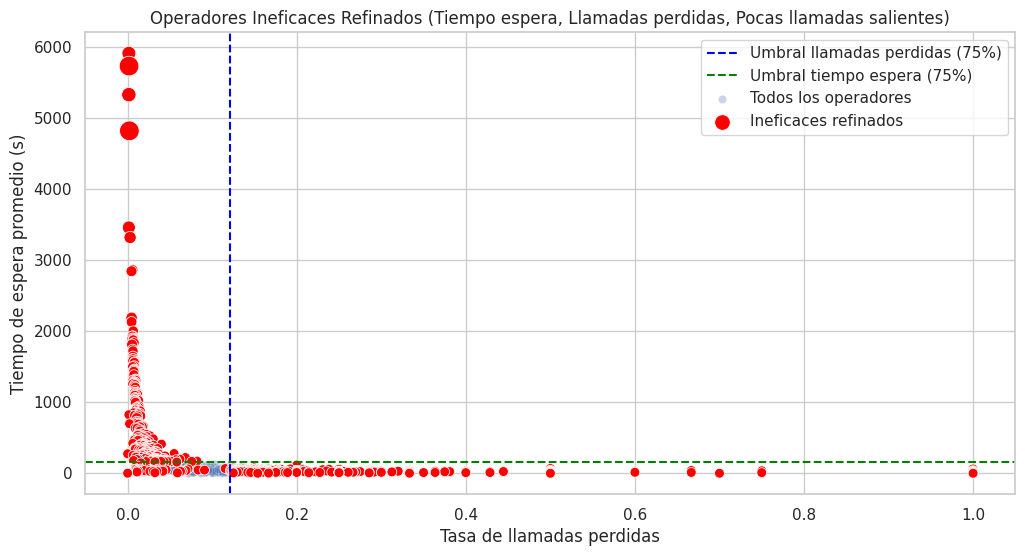

In [53]:
plt.figure(figsize=(12,6))

# Todos los operadores
sns.scatterplot(
    data=operator_stats, 
    x='missed_call_rate', 
    y='avg_waiting_time',
    alpha=0.3, 
    label='Todos los operadores'
)

# Operadores ineficaces refinados
sns.scatterplot(
    data=inefficient_operators_refined, 
    x='missed_call_rate', 
    y='avg_waiting_time',
    size='total_out_calls',
    sizes=(50, 200),  # puntos más pequeños = pocas llamadas
    color='red', 
    legend=False,
    label='Ineficaces refinados'
)

# Líneas de umbral
plt.axvline(x=missed_call_threshold, color='blue', linestyle='--', label='Umbral llamadas perdidas (75%)')
plt.axhline(y=waiting_time_threshold, color='green', linestyle='--', label='Umbral tiempo espera (75%)')

plt.title('Operadores Ineficaces Refinados (Tiempo espera, Llamadas perdidas, Pocas llamadas salientes)')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Tiempo de espera promedio (s)')
plt.legend()
plt.show()

4. ANÁLISIS COMPARATIVO Y PRUEBAS ESTADÍSTICAS

Nuestro siguiente paso es comprobar si las diferencias entre los operadores "ineficaces" y los "eficaces" son estadísticamente significativas. 

In [54]:
# Creamos una columna que marque si el operador es ineficaz
operator_stats['ineficaz'] = operator_stats['operator_id'].isin(inefficient_operators_refined['operator_id'])

# Verificamos distribución de grupos
operator_stats['ineficaz'].value_counts()

True     771
False    321
Name: ineficaz, dtype: int64

In [55]:
# Comparación de métricas entre operadores eficaces e ineficaces
comparacion = operator_stats.groupby('ineficaz')[['avg_waiting_time', 'missed_call_rate', 'total_out_calls']].mean().round(2)
display(comparacion)

,avg_waiting_time,missed_call_rate,total_out_calls
ineficaz,,,
False,66.4,0.07,254.22
True,277.5,0.12,762.30


Hasta ahora podemos ver como los operadores definidos como "ineficaces" muestran tiempo de espera y tasas dfe llamadas perdidas mayores. El número de llamadas salientes podria estar relacionado con intentos repetidos o mala gestión en el flujo de llamadas

In [56]:
eficaces = operator_stats[operator_stats['ineficaz'] == False]
ineficaces = operator_stats[operator_stats['ineficaz'] == True]

# Pruebas Mann–Whitney
for col in ['avg_waiting_time', 'missed_call_rate', 'total_out_calls']:
    stat, p = mannwhitneyu(eficaces[col], ineficaces[col], alternative='two-sided')
    print(f"{col} > Estadístico U: {stat:.2f}, p-valor: {p:.5f}")

avg_waiting_time > Estadístico U: 124592.50, p-valor: 0.85849
missed_call_rate > Estadístico U: 144067.00, p-valor: 0.00002
total_out_calls > Estadístico U: 154119.50, p-valor: 0.00000


Entonces: 

- avg_waiting_time: No hay evidencia estadística de que el tiempo promedio de espera difiera significativamente entre operadores "eficaces" e "ineficaces".
- missed_call_rate: La tasa de llamadas perdidas SI es significativamente mayor en los operadores "ineficaces". Podemos confirmar que si desempeño en atención es peor.
- total_out_calls: La tasa de llamadas salientes también es significativa (aunque no podemos confirmar que + llamadas implica mejor desempeño)

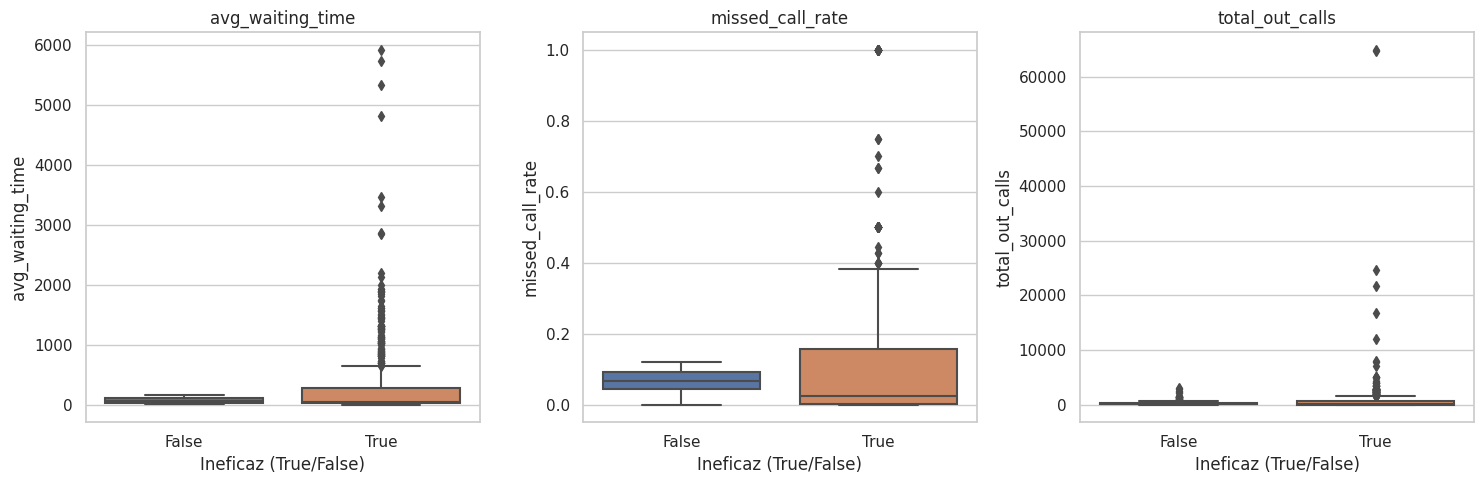

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ['avg_waiting_time', 'missed_call_rate', 'total_out_calls']

for ax, col in zip(axes, metrics):
    sns.boxplot(data=operator_stats, x='ineficaz', y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Ineficaz (True/False)")

plt.tight_layout()
plt.show()

Los gráficos anteriores comparan los operadores **eficaces** e **ineficaces** en tres dimensiones:

1. *Tiempo promedio de espera:*  
   Aunque los operadores ineficaces presentan una mayor variabilidad, la diferencia en medianas no es muy marcada, confirmando los resultados estadísticos (p > 0.05).

2. *Tasa de llamadas perdidas:*  
   Se observa una distribución claramente más alta entre los ineficaces. Este indicador presenta una diferencia estadísticamente significativa (p < 0.05), lo que lo convierte en una métrica clave de desempeño.

3. *Llamadas salientes:*
   Los operadores eficaces muestran una mayor dispersión y volumen de llamadas salientes, mientras que los ineficaces tienden a concentrarse en valores bajos.  
   La diferencia es significativa y apunta a la necesidad de revisar la gestión del tiempo operativo.


Interpretación

- Solo la tasa de llamadas perdidas y las llamadas salientes muestran diferencias estadísticamente significativas entre los grupos.
- El tiempo promedio de espera no difiere significativamente — podrías revisar si hay outliers o si el indicador necesita normalización por carga de trabajo (por ejemplo, llamadas atendidas por operador).

5. CONCLUSIONES

El análisis exploratorio permitió observar que:

- El tiempo de espera promedio por operador presenta una distribución altamente sesgada, con valores máximos que superan los 5,000 segundos.

- La tasa de llamadas perdidas es, en promedio, del 10%, aunque algunos operadores alcanzan hasta el 100%.

- El volumen de llamadas salientes es muy desigual, concentrándose en un grupo reducido de operadores con alta carga de trabajo.

Se establecieron criterios de ineficiencia basados en los percentiles 75 de tiempo de espera y tasa de llamadas perdidas, así como el percentil 25 de llamadas salientes.
Bajo estos umbrales, se identificaron 771 operadores ineficaces, equivalentes al 71% del total.

Las pruebas estadísticas de Mann–Whitney confirmaron que:

- No existen diferencias significativas en tiempo de espera entre operadores eficaces e ineficaces (p = 0.858).

- Sí existen diferencias significativas en la tasa de llamadas perdidas (p = 0.00002) y en el volumen de llamadas salientes (p < 0.0001).

Esto sugiere que la ineficacia se asocia principalmente con una mala gestión de llamadas y altas tasas de abandono, más que con la duración del tiempo de espera.


5. 1 RECOMENDACIONES

- Enfocarse en la reducción de llamadas perdidas: Este es el indicador más fuerte de ineficiencia. Se recomienda reforzar la capacitación en atención simultánea y priorización de llamadas.

- Optimización de la gestión de llamadas salientes: Algunos operadores realizan pocas llamadas salientes, lo que puede indicar falta de proactividad o sobrecarga en llamadas entrantes.
      
- Revisión del tiempo de espera: Aunque no se hallaron diferencias significativas, el promedio de los operadores ineficaces (277.5 s) sigue siendo elevado. Se sugiere analizar la distribución individual y los casos extremos.  

- Reevaluar criterios de desempeño: Ajustar los umbrales (por ejemplo, usar el percentil 80 en lugar del 75) puede ayudar a enfocar las acciones solo en los peores desempeños.
    
- Implementar un monitoreo continuo: Crear dashboards que muestren la evolución de los indicadores por operador en tiempo real permitiría detectar ineficiencias tempranamente.

6. FUENTES Y REFERENCIAS 

*SciPy Stats – Mann–Whitney U Test* 
- Uso: Consultada para la implementación de la prueba estadística que comparó operadores eficaces vs. ineficaces en las métricas clave.
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

*Artículo: “How to Identify Inefficient Employees Using Data” (Medium, 2020)*
- Uso: Inspiró la metodología de definir umbrales basados en percentiles y criterios combinados para detectar operadores ineficaces.

*Matplotlib Documentation*
- Uso: Para gráficos de barras y líneas que apoyaron el análisis visual del comportamiento de los operadores y la distribución de llamadas.
- https://matplotlib.org/stable/users/index.html

*Seaborn Documentation*
- Uso: Para generar visualizaciones exploratorias, incluyendo distribuciones y gráficos de dispersión de variables como tiempo de espera y llamadas perdidas.
- https://seaborn.pydata.org/

7. DASHBOARD

https://public.tableau.com/app/profile/monica.e.baca/viz/CallMeMaybeDashboardMonicaBaca/CallMeMaybe

En el dashboard encontraras los siguientes gráficos dinamicos: 

- Histograma para la duración de la llamada
- Gráfico circular que muestra la participación de las llamadas internas y externas
- Hay un filtro para la "dirección" y "duración" de llamadas

8. PRESENTACIÓN EN PDF 

https://drive.google.com/file/d/1y_xVGKhtDMUiGCtFpllkhNQhblMj0dZu/view?usp=drive_link

<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Éxito</b> - La sección de conclusiones y recomendaciones está muy bien elaborada. Resume con precisión los hallazgos clave, conecta los resultados estadísticos con acciones prácticas y demuestra una comprensión analítica completa del problema. La inclusión de referencias y recursos externos aporta solidez técnica al cierre del proyecto.  
</div>
